In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn import linear_model
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sgf
from scipy.signal import find_peaks
import matplotlib as mpl
'''
A bunch of small helper functions

'''
def scale(array):
    m = max(array)
    return array/m

def zero(array,num1=350):
    return array - np.average(array[num1:])

def binning(array,num):
    binarray=[]
    for i in range(int(len(array)/num)):
        binarray.append(np.average(array[num*i:num*(i+1)]))
    return np.array(binarray)

def flatten(list1):
    return [item for sublist in list1 for item in sublist]

def diffs(array):
    array = np.array(array)
    diff_arr = [array[1] - array[0]] + [(array[i+1]-array[i-1])/2 for i in range(1,len(array)-1)] + [array[-1] - array[-2]]
    return np.array(diff_arr)

def smooth(array,avnum):
    new_arr = [sum(array[i-avnum:i+avnum+1])/(2*avnum+1) for i in range(avnum,len(array)-avnum-1)]
    new_arr.extend(list(array[-1-avnum:]))
    s_arr = list(array[:avnum])
    s_arr.extend(new_arr)
    #print([len(array),len(s_arr)])
    return np.array(s_arr)

def binner(array,avnum):
    new_arr = [sum(array[i:i+avnum])/avnum for i in (range(0,len(array),avnum))]
    return np.array(new_arr)

'''
Main functions and objects used for analysis
'''

def get_plate(filename,search,nA=8,nX=12,splt='\t',discard = 'None'):
    # returns data from the matrix output of the platereader file in a nA x nB x nwavelength np.array
    # filename = the name and directory of the Dynatek Synergy platereader file
    # search = the string which is present at the end of each row. Usually, :Spectrum for absorption and
    # :EMSpectrum for emission
    # nA = the number of rows (A-H) used, usually 8
    # nB = the number of columns (1-12) used, usually 12
    # splt = element used to split the rows of the platereader file, usually a tab ('\t')
    plate = open(filename,'r').read().split('\n')
    plate_data = [[[] for i in range(nX)] for j in range(nA)]
    idict = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7}
    info = '()'
    if 'Spectrum' in search:
        info  = '(A)'
    elif 'EM Spectrum' in search:
        info = '(F)'
        
    index = []
    for i in plate:
        if 'Read' in i.split(splt):
            
            a = i.split(splt)[1].split(' ')
            if info in a:
                
                b = ([float(x.strip('[').strip('nm')) for x in a if 'nm' in x])
                c = ([float(a[i+1].strip(']')) for i in range(len(a)) if a[i] =='by'])
                wavenums = np.arange(b[0],b[1]+1,c[0])
        if search in i and splt in i:
            #print(i.split(splt))
            if discard!='None':
                if discard not in i:
                    li = i.split(splt)
                    ia = li[-1].index('#') - 1
                    b = idict[li[0]]
                    #print (li)
                    li1 = [k for k in li if not k== '']
                    for j in range(len(li1)-1):
                        if not li[0]+str(j) in index:
                            index.append(li[0]+str(j))
                        if li1[j] == 'OVRFLW':
                            plate_data[b][j-1].append(4)
                            #print(li1[j])
                        else:
                            try:
                                plate_data[b][j-1].append(float(li1[j]))
                                #print(li1[j])
                            except ValueError:
                                index.remove(li[0]+str(j))
            else:
                li = i.split(splt)
                ia = li[-1].index('#') - 1
                b = idict[li[0]]
                #print (li)
                li1 = [k for k in li if not k== '']
                for j in range(len(li1)-1):
                    if not li[0]+str(j) in index:
                        index.append(li[0]+str(j))
                    if li1[j] == 'OVRFLW':
                        plate_data[b][j-1].append(4)
                        #print(li1[j])
                    else:
                        try:
                            plate_data[b][j-1].append(float(li1[j]))
                            #print(li1[j])
                        except ValueError:
                            index.remove(li[0]+str(j))

    print(np.array(flatten(plate_data)).shape)
    if not 'wavenums' in locals():
        if info == '(A)':
            wavenums = range(250,701,1)
        elif info == '(F)':
            wavenums = range(400,551,1)
    return pd.DataFrame(np.array(flatten(plate_data)),index,wavenums)

def scat_subtract(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    def fit_func(x,b,a):
        # helper function that defines a line function
        return a+x*b
    
    param_bounds = ([-4,-np.inf],[0,np.inf])
    # the scattering factor b should be no smaller than -4, and no larger than 0 based on physical constraints.
    log = np.log10(np.array(array))
    logw = np.log10(np.array(waves))
    # turn the arrays into logs to fit the power law
    #print(log[num2:num3])
    #print(logw[num2:num3])
    paramslog = curve_fit(fit_func,logw[num2:num3],log[num2:num3],p0 = [-2,1], bounds = param_bounds)
    # fits the parameters on a log scale
    paramslin = [[paramslog[0][0],10**paramslog[0][1]],
                 [np.sqrt(paramslog[1][0][0]),0.434*np.sqrt(paramslog[1][1][1])/paramslog[0][1]]]
    # extracts linear parameters in linear scale from the log plot, including errors (paramslin[1])
    def scat_func (x,b,a):
        return a*x**b
    scatter = scat_func(np.array(waves),paramslin[0][0],paramslin[0][1])
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [2]:
def scat_subtract_noneg(array,waves,num2,num3):
    # subtracts a power law scattering background a*x^b from the array. the power law is fit in the region of num2:num3
    # This means there should be no absorption feature from the sample besides scattering in that region
    
    param_bounds = ([-4,0],[-np.inf,np.inf],[0,min(array) - 0.01])
    #array = array-min(array) +0.001
    def scat_func (x,b,a,c):
        return a*x**b + c
    
    def log_scat_func(x,b,a):
        return b*x + a
    
    def loss_func (x,num2 = num2,num3 = num3,xvals = waves, yvals = array):
        a = x[1]
        b = x[0]
        c = x[2]
        results = scat_func(np.array(xvals),b,10**a,c)
        #print(results)
        #print(yvals)
        log_results = log_scat_func(np.log10(np.array(xvals)),b,a)
        #print(results)
        comp = np.vstack((np.zeros(results.shape[0]),yvals-results))
        #print(comp)
        negs = -(np.min(comp,axis = 0))
        #print(np.sum(negs))
        #print(np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))))
        return np.sum(np.square(log_results[num2:num3]-np.log10(yvals[num2:num3]-c))) + np.sum(negs)
    
    res = minimize(loss_func,[-1,0.01,0.1], bounds = param_bounds, method = 'L-BFGS-B',options = {'gtol': 1e-10})    
    #plt.figure(1)
    #log_results = log_scat_func(np.log10(np.array(waves)),res.x[0],res.x[1])
    #plt.plot(np.log10(np.array(waves)),log_results)
    #plt.plot(np.log10(np.array(waves)),np.log10(array-res.x[2]))
    #plt.show()
    scatter = scat_func(np.array(waves),res.x[0],10**res.x[1],res.x[2])
    print(res)
    # creates scatter function based on the parameters extracted
    # returns the initial array minus the calculated scatter function
    return array-scatter

In [3]:
absorption2 = get_plate('05122021_AuNR_nd (0001).txt','Spectrum Read')

amts = pd.read_csv('Nimbus Input 05122021.csv',index_col = 0,usecols = [0,1,2,3,4,5,6,7])

(96, 700)


In [4]:
amts[(amts['NaBH4'] +  amts['NaBH4_2nd']==60) & (amts['CTAB']==160)]

,H2O,CTAB,Au,Ag,HQ,NaBH4,NaBH4_2nd
A10,173,160,50,40,17,60,0
C10,173,160,50,40,17,60,0
E10,173,160,50,40,17,60,0
G10,173,160,50,40,17,60,0
B10,173,160,50,40,17,30,30
D10,173,160,50,40,17,30,30
F10,173,160,50,40,17,30,30
H10,173,160,50,40,17,30,30
A11,173,160,50,40,17,9,51
C11,173,160,50,40,17,9,51


In [5]:
amts_select = amts.iloc[:81,:]

In [6]:
merge = pd.merge(amts,absorption2,left_index = True, right_index = True)
merge['tNaBH4'] = merge['NaBH4'] + merge['NaBH4_2nd']
merge['rNaBH4'] = merge['NaBH4'] / merge['tNaBH4']
print(merge)
merge.to_csv('AuNR05122021_merged.csv')

     H2O  CTAB  Au  Ag  HQ  NaBH4  NaBH4_2nd  300.0  301.0  302.0  ...  992.0  \
A1   174   160  50  25  51     40          0  3.550  3.360  3.206  ...  0.271   
C1   173   160  51  25  51     40          0  3.432  3.253  3.046  ...  0.486   
E1   175   160  50  25  50     40          0  3.435  3.242  3.044  ...  0.360   
G1   174   160  51  25  50     40          0  3.387  3.224  3.070  ...  0.265   
B1   150   160  50  50  50     40          0  3.568  3.452  3.250  ...  0.332   
..   ...   ...  ..  ..  ..    ...        ...    ...    ...    ...  ...    ...   
G12  273   100  50  40  17     10         10  1.823  1.709  1.604  ...  0.307   
B12  273   100  50  40  17      5         15  1.768  1.655  1.554  ...  0.287   
D12  273   100  50  40  17      5         15  1.942  1.825  1.716  ...  0.338   
F12  273   100  50  40  17      5         15  1.589  1.489  1.403  ...  0.318   
H12  293   100  50  40  17      0          0  1.541  1.423  1.315  ...  0.297   

     993.0  994.0  995.0  9

In [7]:
Fact = merge[~merge.index.isin(['A' + str(i) for i in range(1,13)]+['B' + str(i) for i in range(1,13)])]
print(Fact)

     H2O  CTAB  Au  Ag  HQ  NaBH4  NaBH4_2nd  300.0  301.0  302.0  ...  992.0  \
C1   173   160  51  25  51     40          0  3.432  3.253  3.046  ...  0.486   
E1   175   160  50  25  50     40          0  3.435  3.242  3.044  ...  0.360   
G1   174   160  51  25  50     40          0  3.387  3.224  3.070  ...  0.265   
D1   149   160  51  50  50     40          0  3.435  3.278  3.041  ...  0.534   
F1   149   160  51  50  50     40          0  3.536  3.338  3.175  ...  0.402   
..   ...   ...  ..  ..  ..    ...        ...    ...    ...    ...  ...    ...   
E12  273   100  50  40  17     10         10  1.656  1.547  1.449  ...  0.330   
G12  273   100  50  40  17     10         10  1.823  1.709  1.604  ...  0.307   
D12  273   100  50  40  17      5         15  1.942  1.825  1.716  ...  0.338   
F12  273   100  50  40  17      5         15  1.589  1.489  1.403  ...  0.318   
H12  293   100  50  40  17      0          0  1.541  1.423  1.315  ...  0.297   

     993.0  994.0  995.0  9

[25 40 50 75]
[0.15       0.25       0.26666667 0.5        1.                nan]
[17 50 51]
[ 0 20 30 40 60]


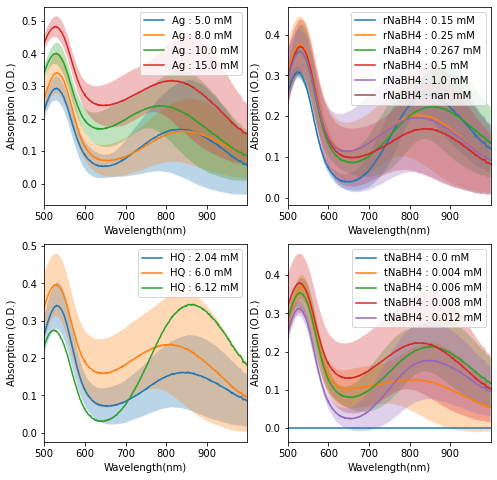

In [8]:
fig,ax = plt.subplots(2,2,figsize = (8,8))
labels = ['Ag','rNaBH4','HQ','tNaBH4']
absorption = np.arange(400.0,1000.0,1.0)
ax = flatten(ax)
concs = [100.0/500.0,1.0,60.0/500.0,0.1/500.0]
for i in range(4):
    sorts = Fact[labels[i]].unique()
    sorts.sort()
    print(sorts)
    for sort in sorts:
        subsel = Fact[Fact[labels[i]] == sort]
        average = subsel[absorption].mean()- absorption2.loc['H12',absorption]
        std = subsel[absorption].std()
        ax[i].plot(absorption, average, label = labels[i] + ' : ' + str(round(sort*concs[i],3)) + ' mM')
        ax[i].fill_between(absorption, average-std,average+std,alpha = 0.3)
    ax[i].legend()
    ax[i].set_xlabel('Wavelength(nm)')
    ax[i].set_ylabel('Absorption (O.D.)')
    ax[i].set_xlim(500,999)
plt.show()
    

In [9]:
Nirvana2 = pd.read_csv('05122021_AuNR_nd.txt',header = 0,index_col = 0,delimiter = '\t')
Nirvana2 = Nirvana2.transpose()
Nirvana2.loc['H12'].to_csv('temp.csv')


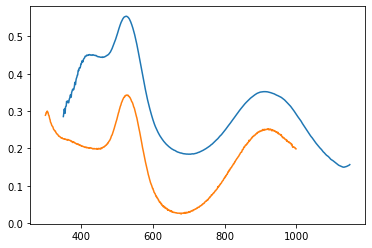

In [13]:
nx = 45
plt.plot(Nirvana2.columns[:800],np.concatenate((Nirvana2.iloc[nx,:651],Nirvana2.iloc[nx,651:800]+diff[nx])))
plt.plot(absorption2.columns,absorption2.iloc[nx,:] - absorption2.iloc[-1,:])
plt.show()

In [14]:
Nirvana2_sc = pd.DataFrame(columns = Nirvana2.columns[100:800])
for nx in range(95):
    data2 = absorption2.iloc[nx,150:] - absorption2.iloc[-1,150:] - Nirvana2.iloc[nx,100:650]
    offset = np.average(data2)
    data = pd.Series(np.concatenate((Nirvana2.iloc[nx,100:651],Nirvana2.iloc[nx,651:800]+diff[nx])),index = Nirvana2_sc.columns, name = absorption2.index[nx])
    data = data-offset
    data = data-data.min()
    
    Nirvana2_sc = Nirvana2_sc.append(data)

In [16]:
Nirvana2_scmerge = pd.merge(amts.iloc[:-1,:],Nirvana2_sc,right_index = True, left_index = True)
Nirvana2_scmerge['tNaBH4'] = Nirvana2_scmerge['NaBH4'] + Nirvana2_scmerge['NaBH4_2nd']
Nirvana2_scmerge['rNaBH4'] = Nirvana2_scmerge['NaBH4'] / Nirvana2_scmerge['tNaBH4']
print(Nirvana2_scmerge)

     H2O  CTAB  Au  Ag  HQ  NaBH4  NaBH4_2nd     450.0     451.0     452.0  \
A1   174   160  50  25  51     40          0  0.351728  0.351796  0.351633   
C1   173   160  51  25  51     40          0  0.275223  0.274651  0.274555   
E1   175   160  50  25  50     40          0  0.316097  0.316165  0.316159   
G1   174   160  51  25  50     40          0  0.345990  0.346342  0.345978   
B1   150   160  50  50  50     40          0  0.463623  0.462779  0.462592   
..   ...   ...  ..  ..  ..    ...        ...       ...       ...       ...   
E12  273   100  50  40  17     10         10  0.298090  0.298187  0.298586   
G12  273   100  50  40  17     10         10  0.368427  0.368103  0.367790   
B12  273   100  50  40  17      5         15  0.363032  0.362793  0.363032   
D12  273   100  50  40  17      5         15  0.393425  0.392169  0.390972   
F12  273   100  50  40  17      5         15  0.310461  0.309534  0.309717   

     ...    1142.0    1143.0    1144.0    1145.0    1146.0    1

In [17]:
Nirvana2_scmerge.to_csv('Nirvana_data_processed.csv')

In [18]:

Fact2_N = Nirvana2_scmerge[Nirvana2_scmerge.index.isin(amts_select.index)]

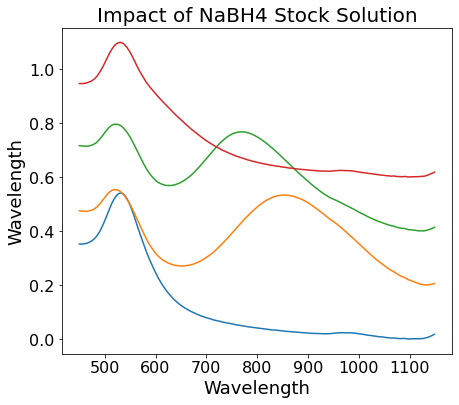

In [20]:
# fig,ax = plt.plot(3,4,figsize = (10,13),sharex = True, sharey = True)
# ax = [a for sublist in ax for a in sublist]
plt.figure(figsize = (7.0, 6.0))

absorption = np.arange(450.0,1150.0,1.0)
# for b in range(1,13):
b = 1 
num = 0
for val in 'ACEG':
    if not val+str(b) =='H12':
        plt.plot(absorption, Nirvana2_scmerge.loc[val+str(b),absorption] + num,label = val+str(b))
        num +=0.2
# plt.legend()
fig.tight_layout()
plt.title('Impact of NaBH4 Stock Solution', fontsize=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Wavelength', fontsize = 18)
plt.ylabel('Wavelength', fontsize = 18)
plt.show()